In [2]:
import torch
import torchvision
from torch import optim
from torchvision import transforms, utils
from torchvision.transforms import InterpolationMode
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import math
import os
import matplotlib.pyplot as plt
import skimage.io as skio
import skimage
import scipy
from scipy.ndimage import zoom
from torch.utils.data import Dataset, DataLoader

In [3]:
feature_points = []
images = []
file_names = os.listdir("imm_face_db")
file_names.sort()
count = 0

In [4]:
for name in file_names:
    if name[-3:] == "asf":
        feature = np.loadtxt("imm_face_db/" + name,
            skiprows = 16, max_rows = 58)[:, [2, 3]]
        feature_points.append(feature)
    if name[-3:] == "jpg":
        image = skio.imread("imm_face_db/" + name)
        images.append(image)

In [5]:
class TrainingDataset(Dataset):
    """Load training data for full facial feature detection. """

    def __init__(self, transform = None, display = True, rescale_factor = 1/8):
        """
        Args:
            transform: Potential transformations imposed on the image.
            display: Whether to display sampled training images.
            rescale factor: rescale the image to smaller size in order to
                decrease computation complexity.
            
        """
        if display:
            height, width = images[0].shape[:2]
            for i in range(4):
                plt.imshow(images[i])
                plt.plot(feature_points[i][-6, 0] * width,
                    feature_points[i][-6, 1] * height,
                    linestyle = "none", marker = ".")
                plt.show()

        self.feature_points = np.array(feature_points[:192]).astype(np.float32)

        self.images = np.array(images[:192])
        self.images = skimage.color.rgb2gray(self.images)
        self.images = zoom(self.images, [1, rescale_factor, rescale_factor],
            order = 1, mode = "reflect")
        self.images = self.images.astype(np.float32) - 0.5


    def __len__(self):
        return self.feature_points.shape[0]


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.images[idx]
        feature = self.feature_points[idx]
        sample = {'image': image, 'feature': feature}

        return sample

class ValidationDataset(Dataset):
    """Load validation data for full facial feature detection. """

    def __init__(self, transform = None, rescale_factor = 1/8):
        """
        Args:
            transform: Potential transformations imposed on the image.
            rescale factor: rescale the image to smaller size in order to
                decrease computation complexity.
        """

        self.feature_points = np.array(feature_points[192:]).astype(np.float32)

        self.images = np.array(images[192:])
        self.images = skimage.color.rgb2gray(self.images)
        self.images = zoom(self.images, [1, rescale_factor, rescale_factor],
            order = 1, mode = "reflect")
        self.images = self.images.astype(np.float32) - 0.5


    def __len__(self):
        return self.feature_points.shape[0]


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.images[idx]
        feature = self.feature_points[idx]
        sample = {'image': image, 'feature': feature}


        return sample

def training_dataloader(batch_size = 8, rescale_factor = 1/8):
    training_data = TrainingDataset(display =  False,
        rescale_factor = rescale_factor)
    return training_data, \
        DataLoader(training_data, batch_size = batch_size, shuffle=False)

def validation_dataloader(rescale_factor = 1/8):
    validation_data = ValidationDataset(rescale_factor = rescale_factor)
    return validation_data, \
        DataLoader(validation_data, batch_size = len(validation_data))


In [6]:
def rotate(x, y, angles):
    """
    Rotate the image and find corresponding rotated feature points. 
    For each angle in angles, rotate all images in batch x with that angle. 
    """
    x_rotated_lst = []
    y_rotated_lst = []
    for angle in angles:
        rotation_matrix = np.array([[np.cos(-angle / 180 * np.pi),
            np.sin(-angle / 180 * np.pi)],
            [-np.sin(-angle / 180 * np.pi),
            np.cos(-angle / 180 * np.pi)]]).astype(np.float32)
        x_rotated = torchvision.transforms.functional.affine(x, angle = angle,
            translate = [0, 0], scale = 1, shear = [0, 0], fill = -0.5)
        y_rotated = y.clone()
        y_rotated[:, :, 0] = y_rotated[:, :, 0] * width - width // 2
        y_rotated[:, :, 1] = y_rotated[:, :, 1] * height - height // 2
        y_rotated = torch.matmul(y_rotated, torch.from_numpy(rotation_matrix.T))
        y_rotated[:, :, 0] = (y_rotated[:, :, 0] + width // 2) / width
        y_rotated[:, :, 1] = (y_rotated[:, :, 1] + height // 2) / height
        x_rotated_lst.append(x_rotated)
        y_rotated_lst.append(y_rotated)
    return x_rotated_lst, y_rotated_lst

def shift_vertical(x, y, pixels):
    """
    Shift the image vertically and find corresponding shifted feature points. 
    For each pixel value in pixels, shift all images in batch x with that pixel. 
    """
    x_shifted_lst = []
    y_shifted_lst = []
    for pixel in pixels:
        x_shifted_vertical = torchvision.transforms.functional.affine(x,
            angle = 0, translate = [0, pixel], scale = 1,
            shear = [0, 0], fill = -0.5)
        y_shifted_vertical = y.clone()
        y_shifted_vertical[:, :, 1] = y_shifted_vertical[:, :, 1] + \
            pixel / height
        x_shifted_lst.append(x_shifted_vertical)
        y_shifted_lst.append(y_shifted_vertical)
    return x_shifted_lst, y_shifted_lst

def shift_horizontal(x, y, pixels):
    """
    Shift the image horizontally and find corresponding shifted feature points. 
    For each pixel value in pixels, shift all images in batch x with that pixel. 
    """
    x_shifted_lst = []
    y_shifted_lst = []
    for pixel in pixels:
        x_shifted_horizontal = torchvision.transforms.functional.affine(x,
            angle = 0, translate = [pixel, 0], scale = 1,
            shear = [0, 0], fill = -0.5)
        y_shifted_horizontal = y.clone()
        y_shifted_horizontal[:, :, 0] = y_shifted_horizontal[:, :, 0] + \
            pixel / width
        x_shifted_lst.append(x_shifted_horizontal)
        y_shifted_lst.append(y_shifted_horizontal)
    return x_shifted_lst, y_shifted_lst


In [7]:
class FacialNet(nn.Module):
    """
    Neural network used to detect full facial features. 
    """
    def __init__(self):
        super(FacialNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, 5, padding = (2, 2))
        self.norm1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(12, 24, 5, padding = (2, 2))
        self.norm2 = nn.BatchNorm2d(24)
        self.conv3 = nn.Conv2d(24, 32, 5, padding = (2, 2))
        self.norm3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, 5, padding = (2, 2))
        self.norm4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 128, 5, padding = (2, 2))
        self.norm5 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(8960, 2640)
        self.norm_fc1 = nn.BatchNorm1d(2640)
        self.fc2 = nn.Linear(2640, 512)
        self.norm_fc2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 116)

        # self.fc1 = nn.Linear(4480, 512)
        # self.norm_fc1 = nn.BatchNorm1d(512)
        # self.fc2 = nn.Linear(512, 116)

    def forward(self, x):
        x = self.conv1(x)
        # x = self.norm1(x)
        x = F.relu(x)
        # x = F.avg_pool2d(x, (2, 2))

        x = self.conv2(x)
        # x = self.norm2(x)
        x = F.relu(x)
        # x = F.avg_pool2d(x, (2, 2))

        x = self.conv3(x)
        # x = self.norm3(x)
        x = F.relu(x)

        x = self.conv4(x)
        # x = self.norm4(x)
        x = F.relu(x)
        x = F.avg_pool2d(x, (4, 4))

        x = self.conv5(x)
        x = self.norm5(x)
        x = F.relu(x)
        x = F.avg_pool2d(x, (4, 4))

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.norm_fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = self.norm_fc2(x)
        x = F.relu(x)

        x = self.fc3(x)

        return x

In [ ]:
# Define hyperparameters. 
batch_size = 32
rotation_per_batch = 1
shift_vertical_per_batch = 1
shift_horizontal_per_batch = 1
np.random.seed(1234)

training_data, training_loader = training_dataloader(batch_size,
    rescale_factor = 1/4)
validation_data, validation_loader = validation_dataloader(rescale_factor = 1/4)

num_epoch = 200
training_losses = []
validation_losses = []

height, width = training_data[0]["image"].shape[0], \
    training_data[0]["image"].shape[1]
rotation_angles = np.random.rand(len(training_data) // batch_size,
    rotation_per_batch) * 30 - 15
pixels_vertical = np.random.randint(-10, 10,
    (len(training_data) // batch_size, shift_vertical_per_batch))
pixels_horizontal = np.random.randint(-10, 10,
    (len(training_data) // batch_size, shift_vertical_per_batch))

model = FacialNet().to("cuda")
optimizer = optim.Adam(model.parameters(), lr = 4e-3)
criterion = nn.MSELoss()

# Train neural net for 200 epochs. 
for epoch in range(num_epoch):
    print(f"Start training epoch {epoch}")
    loss_epoch = []
    for i, batch in enumerate(training_loader):
        x = batch["image"]
        y = batch["feature"]

        angles = rotation_angles[i]
        x_rotated_lst, y_rotated_lst = rotate(x, y, angles)
        # rotation_matrix = np.array([[np.cos(-angle / 180 * np.pi),
        #     np.sin(-angle / 180 * np.pi)],
        #     [-np.sin(-angle / 180 * np.pi),
        #     np.cos(-angle / 180 * np.pi)]]).astype(np.float32)
        # x_rotated = torchvision.transforms.functional.affine(x, angle = angle,
        #     translate = [0, 0], scale = 1, shear = [0, 0], fill = -0.5)
        # y_rotated = y.clone()
        # y_rotated[:, :, 0] = y_rotated[:, :, 0] * width - width // 2
        # y_rotated[:, :, 1] = y_rotated[:, :, 1] * height - height // 2
        # y_rotated = torch.matmul(y_rotated, torch.from_numpy(rotation_matrix.T))
        # y_rotated[:, :, 0] = (y_rotated[:, :, 0] + width // 2) / width
        # y_rotated[:, :, 1] = (y_rotated[:, :, 1] + height // 2) / height
        # plt.imshow(x_rotated_lst[0][0].numpy() + 0.5, cmap = "gray")
        # print("begin plot")
        # print(y_rotated_lst[0][0].numpy()[:, 0] * width)
        # print(y_rotated_lst[0][0].numpy()[:, 1] * height)
        # plt.plot(y_rotated_lst[0][0].numpy()[:, 0] * width, y_rotated_lst[0][0].numpy()[:, 1] * height,
        #     linestyle = "none", marker = ".", markersize = 3, color="b")
        # print("end plot")
        # plt.show()

        pixels = pixels_vertical[i]
        x_shifted_vertical_lst, y_shifted_vertical_lst = shift_vertical(x, y, pixels)
        # x_shifted_vertical = torchvision.transforms.functional.affine(x,
        #     angle = 0, translate = [0, pixels_vertical[i]], scale = 1,
        #     shear = [0, 0], fill = -0.5)
        # y_shifted_vertical = y.clone()
        # y_shifted_vertical[:, :, 1] = y_shifted_vertical[:, :, 1] + \
        #     pixels_vertical[i] / height
        # plt.imshow(x_shifted_lst[0][0].numpy() + 0.5, cmap = "gray")
        # plt.plot(y_shifted_lst[0][0].numpy()[:, 0] * width,
        #     y_shifted_lst[0][0].numpy()[:, 1] * height,
        #     linestyle = "none", marker = ".", markersize = 3, color="b")
        # plt.show()


        pixels = pixels_horizontal[i]
        x_shifted_horizontal_lst, y_shifted_horizontal_lst = shift_horizontal(x, y, pixels)
        # x_shifted_horizontal = torchvision.transforms.functional.affine(x,
        #     angle = 0, translate = [pixels_vertical[i], 0], scale = 1,
        #     shear = [0, 0], fill = -0.5)
        # y_shifted_horizontal = y.clone()
        # y_shifted_horizontal[:, :, 0] = y_shifted_horizontal[:, :, 0] + \
        #     pixels_vertical[i] / width
        # plt.imshow(x_shifted_lst[0][0].numpy() + 0.5, cmap = "gray")
        # plt.plot(y_shifted_lst[0][0].numpy()[:, 0] * width,
        #     y_shifted_lst[0][0].numpy()[:, 1] * height,
        #     linestyle = "none", marker = ".", markersize = 3, color="b")
        # plt.show()

        x = torch.cat(tuple(x_rotated_lst + x_shifted_vertical_lst + x_shifted_horizontal_lst + [x]),
            axis = 0)
        y = torch.cat(tuple(y_rotated_lst + y_shifted_vertical_lst + y_shifted_horizontal_lst + [y]),
            axis = 0).to("cuda")
        x = x.unsqueeze(1)

        output = model(x.to("cuda"))
        loss = criterion(torch.flatten(y, 1), output).float()
        loss_epoch.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del loss
        del output

    training_losses.append(np.mean(loss_epoch))
    model.eval()
    for i, batch in enumerate(validation_loader):
        validation_x = batch["image"].unsqueeze(1).to("cuda")
        validation_y = batch["feature"].to("cuda")
        validation_output = model(validation_x)
        validation_loss = criterion(torch.flatten(validation_y, 1),
            validation_output).float()
        print(validation_loss)
        validation_losses.append(validation_loss.item())
    model.train()
    print(torch.cuda.memory_allocated(0)/(1024**3))

120 160
Start displaying training results. 


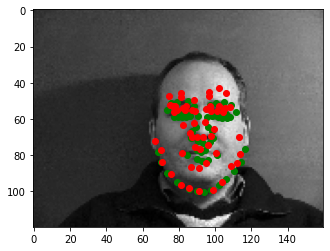

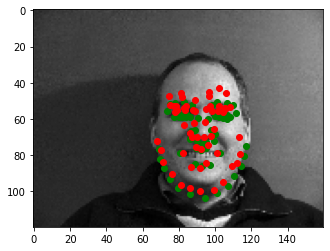

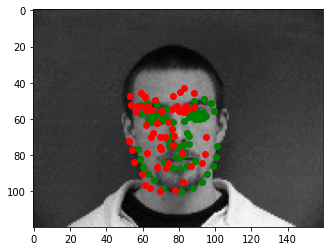

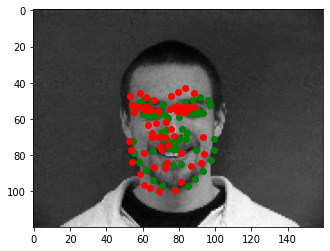

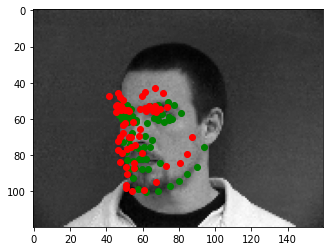

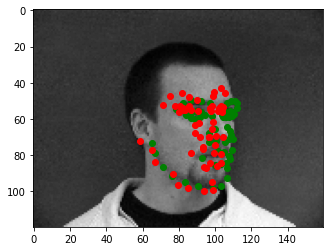

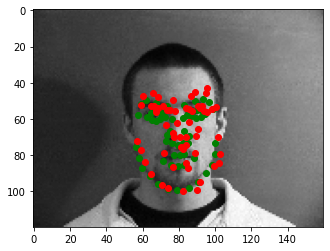

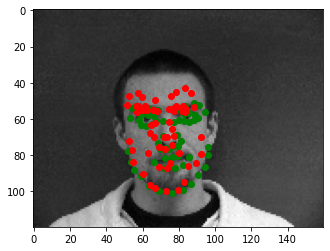

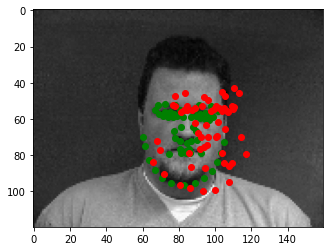

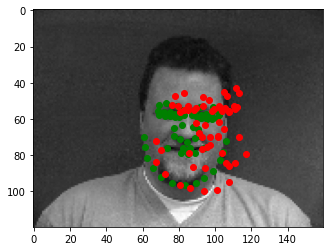

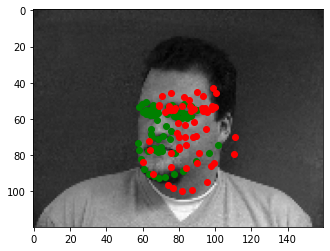

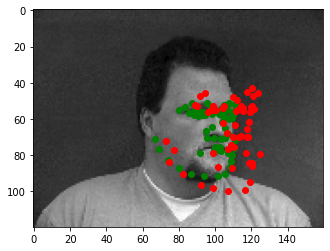

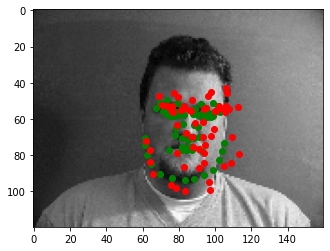

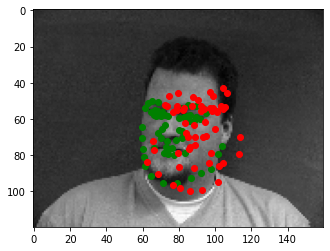

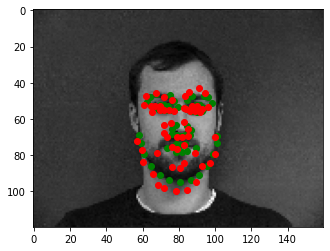

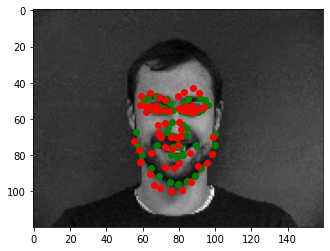

Start displaying validation results. 


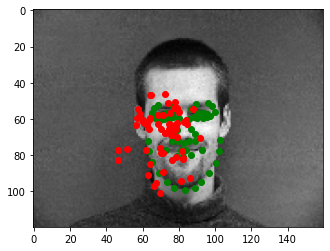

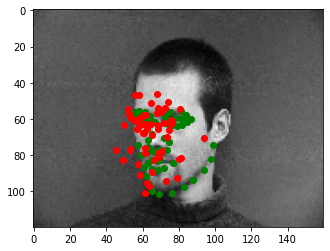

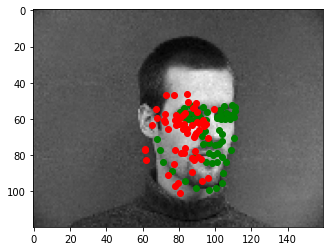

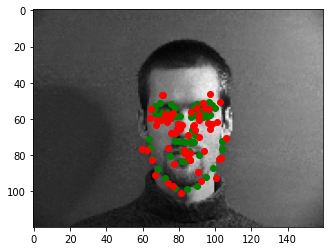

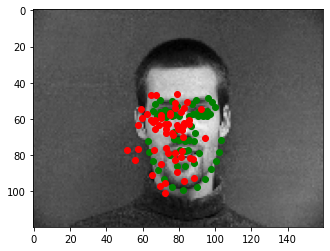

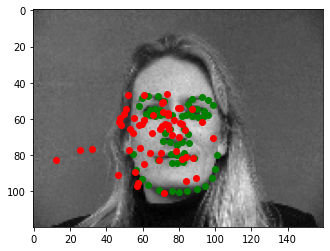

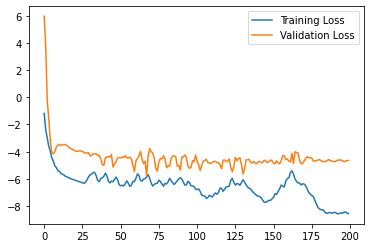

In [9]:
# Display training and validation results. 
model.eval()
print(height, width)
print("Start displaying training results. ")
for i, batch in enumerate(training_loader):
    training_x = batch["image"].unsqueeze(1)
    training_y = batch["feature"]
    training_output = model.to("cpu")(training_x)
    num_features = list(training_output.shape)[1] // 2
    for j in range(batch_size // 2, batch_size):
        plt.imshow(batch["image"][j].numpy() + 0.5, cmap = "gray")
        plt.plot(batch["feature"][j].numpy()[:, 0] * width,
            batch["feature"][j].numpy()[:, 1] * height, linestyle = "none",
            marker = ".", markersize = 12, color = 'g')
        plt.plot(training_output[j].detach().numpy()[::2] * width,
            training_output[i].detach().numpy()[1::2] * height,
            linestyle = "none", marker = ".", markersize = 12, color = 'r')
        plt.show()
    break

print("Start displaying validation results. ")
for i, batch in enumerate(validation_loader):
    validation_x = batch["image"].unsqueeze(1)
    validation_y = batch["feature"]
    validation_output = model(validation_x)
    num_features = list(validation_output.shape)[1] // 2
    for j in range(7, 13):
        plt.imshow(batch["image"][j].numpy() + 0.5, cmap = "gray")
        plt.plot(batch["feature"][j].numpy()[:, 0] * width,
            batch["feature"][j].numpy()[:, 1] * height, linestyle = "none",
            marker = ".", markersize = 12, color = 'g')
        plt.plot(validation_output[j].detach().numpy()[::2] * width,
            validation_output[i].detach().numpy()[1::2] * height,
            linestyle = "none", marker = ".", markersize = 12, color = 'r')
        plt.show()

# Plot training and validation loss curves. 
plt.plot(list(range(num_epoch)), np.log(training_losses),
    label = "Training Loss")
plt.plot(list(range(num_epoch)), np.log(validation_losses),
    label = "Validation Loss")
plt.legend()
plt.show()


begin original plot


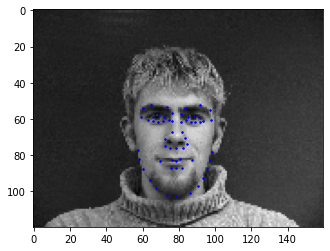

begin rotation plot


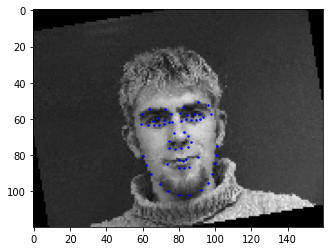

begin horizontal shift plot


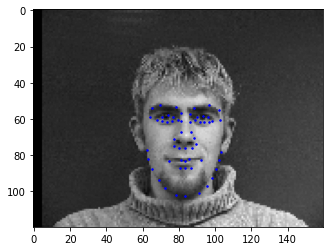

begin vertical shift plot


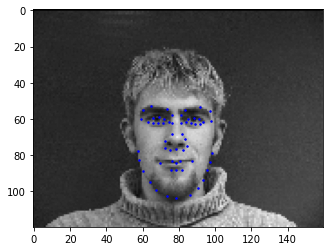

In [11]:
# Visualize augmented images. 
for i, batch in enumerate(training_loader):
  x = batch["image"]
  y = batch["feature"]
  angles = rotation_angles[i]
  horizontal_pixels = pixels_horizontal[i]
  vertical_pixels = pixels_vertical[i]

  x_rotated_lst, y_rotated_lst = rotate(x, y, angles)
  x_shifted_horizontal_lst, y_shifted_horizontal_lst = shift_horizontal(x, y, horizontal_pixels)
  x_shifted_vertical_lst, y_shifted_vertical_lst = shift_vertical(x, y, vertical_pixels)

  print("begin original plot")
  plt.imshow(x[0].numpy() + 0.5, cmap = "gray")
  plt.plot(y[0].numpy()[:, 0] * width, y[0].numpy()[:, 1] * height,
      linestyle = "none", marker = ".", markersize = 3, color="b")
  plt.show()

  print("begin rotation plot")
  plt.imshow(x_rotated_lst[0][0].numpy() + 0.5, cmap = "gray")
  plt.plot(y_rotated_lst[0][0].numpy()[:, 0] * width, y_rotated_lst[0][0].numpy()[:, 1] * height,
      linestyle = "none", marker = ".", markersize = 3, color="b")
  plt.show()

  print("begin horizontal shift plot")
  plt.imshow(x_shifted_horizontal_lst[0][0].numpy() + 0.5, cmap = "gray")
  plt.plot(y_shifted_horizontal_lst[0][0].numpy()[:, 0] * width, 
           y_shifted_horizontal_lst[0][0].numpy()[:, 1] * height,
           linestyle = "none", marker = ".", markersize = 3, color="b")
  plt.show()

  print("begin vertical shift plot")
  plt.imshow(x_shifted_vertical_lst[0][0].numpy() + 0.5, cmap = "gray")
  plt.plot(y_shifted_vertical_lst[0][0].numpy()[:, 0] * width, 
           y_shifted_vertical_lst[0][0].numpy()[:, 1] * height,
           linestyle = "none", marker = ".", markersize = 3, color="b")
  plt.show()

  break

  

(12, 1, 5, 5)
(60, 5)
(24, 12, 5, 5)
(120, 60)
(32, 24, 5, 5)
(160, 120)
(64, 32, 5, 5)
(320, 160)
(128, 64, 5, 5)
(640, 320)


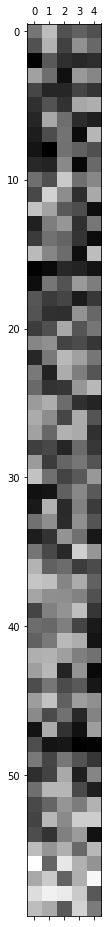

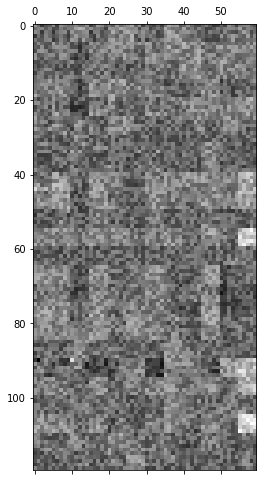

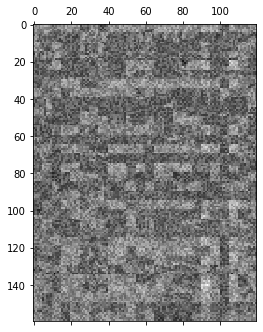

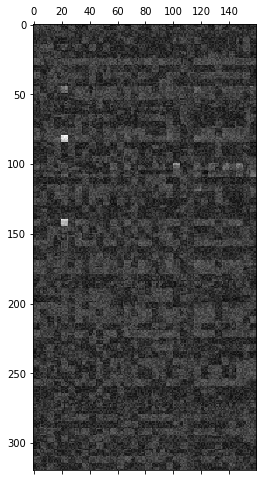

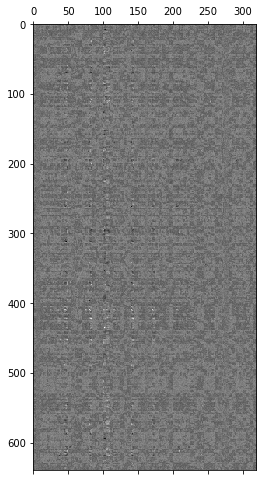

In [28]:
# Visualize filters. 
conv_weights = [model.conv1.weight.data.numpy(), model.conv2.weight.data.numpy(), 
                model.conv3.weight.data.numpy(), model.conv4.weight.data.numpy(),
                model.conv5.weight.data.numpy()]

for conv_weight in conv_weights:
  print(conv_weight.shape)
  conv_list = []
  for i in range(conv_weight.shape[0]):
    conv_layer = []
    for j in range(conv_weight.shape[1]):
      conv_layer.append(conv_weight[i, j])
    conv_layer = np.concatenate(conv_layer, axis = 1)
    conv_list.append(conv_layer)
  conv_list = np.concatenate(conv_list, axis = 0)
  print(conv_list.shape)
  plt.matshow(conv_list, cmap = "gray")